## In this notebook we will calculate phytoplankton populations biomass <br> and clean the data to make it ready for exploration and quality control 

In [1]:
#Running data ingest python notebook

%run 01_data-ingest.ipynb

In [2]:
seaflow.head(5)

,lat,lon,depth,cruise,abundance_prochloro,abundance_synecho,abundance_picoeuk,abundance_croco,diam_prochloro,diam_synecho,diam_picoeuk,diam_croco,Qc_prochloro,Qc_synecho,Qc_picoeuk,Qc_croco,biomass_prochloro,biomass_synecho,biomass_picoeuk,biomass_croco
time,,,,,,,,,,,,,,,,,,,,
2010-05-04 23:13:08,49.9424,-136.3091,5,TN248,NaN,9.450561,42.470594,0.000000,NaN,0.972847,1.156123,NaN,NaN,0.139359,0.217537,NaN,NaN,1.317022,9.238921,0.000000
2010-05-04 23:16:08,49.9424,-136.3091,5,TN248,NaN,9.719664,44.614850,0.045525,NaN,0.963412,1.150068,2.736205,NaN,0.135899,0.214609,2.379907,NaN,1.320895,9.574742,0.108346
2010-05-04 23:19:08,49.9424,-136.3091,5,TN248,NaN,9.955824,44.106351,0.000000,NaN,0.972847,1.147056,NaN,NaN,0.139359,0.213163,NaN,NaN,1.387435,9.401822,0.000000
2010-05-04 23:22:08,49.9424,-136.3091,5,TN248,NaN,11.054114,43.395945,0.022792,NaN,0.960294,1.142564,4.366571,NaN,0.134768,0.211015,6.707313,NaN,1.489737,9.157209,0.152873
2010-05-04 23:28:08,49.9424,-136.3091,5,TN248,NaN,9.504259,40.182275,0.045584,NaN,0.972847,1.166330,3.305096,NaN,0.139359,0.222525,3.287736,NaN,1.324505,8.941571,0.149868


## To omplimize the amount of data we need to deal with<br>we will drop unessasary columns

Variables that will be used for this random forest regression model are that are needed are below.

For analysis of the model:
- time
- lat
- lon
To train the model:
- temperature
- salinity
- biomass
- NO3
- PO4
- Fe
- Si
- chl

We only need the differnt phytoplankton populations <u>biomass</u> and <u>spatio-temporal</u> data from SeaFlow. 


In [ ]:
# Iterate over the plankton types
plankton_types = ['prochloro', 'synecho', 'picoeuk', 'croco']
for plankton_type in plankton_types:
    # Calculate plankton volume
    plankton_volume = (4/3) * math.pi * (realtime_cmap['diam_' + plankton_type] / 2) ** 3

    # Calculate carbon quota
    carbon_quota = 0.261 * plankton_volume ** 0.86

    # Calculate biomass by multiplying abundance with carbon quota (multiply by 1000 to convert to pgC per L)
    realtime_cmap['biomass_' + plankton_type] = realtime_cmap['abundance_' + plankton_type] * carbon_quota * 1000

### Checking for NaN Values

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_nans(df):
    """
    This function takes a DataFrame and determines if there are NaN values. If there are NaN values, it returns a
    DataFrame that has the ratio of NaN values for each column, along with a bar graph showing the ratio of NaNs.
    """
    nan_counts = df.isnull().sum()
    total_rows = len(df)
    
    if nan_counts.sum() != 0:
        nan_ratio = nan_counts / total_rows * 100
        nan_df = pd.DataFrame({'Variables': nan_ratio.index, 'Ratio of Data Missing': nan_ratio.values})
        nan_df = nan_df[nan_df['Ratio of Data Missing'] > 0].sort_values(by='Ratio of Data Missing', ascending=False)
        
        # Plotting the NaN values
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(nan_df['Variables'], nan_df['Ratio of Data Missing'])
        plt.xticks(rotation=45, ha='right')
        ax.set_title('Missing Data of Covariate DataFrame')
        ax.set_ylabel('NaNs (%)')
        ax.grid(axis='y')
        plt.tight_layout()
        plt.show()
        
        return nan_df
    else:
        print("No NaNs found. Yay!")
        return None


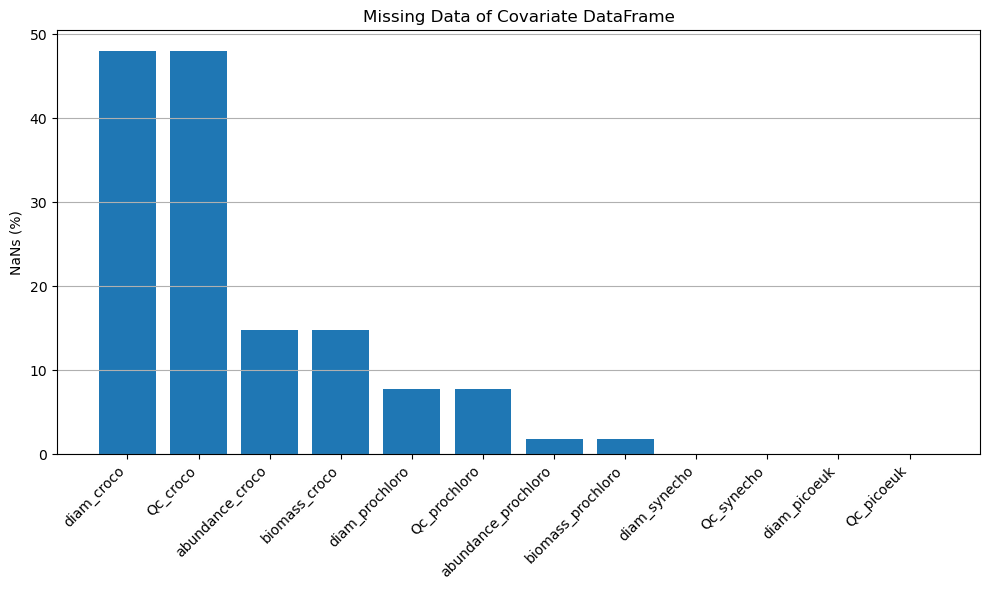

,Variables,Ratio of Data Missing
11,diam_croco,48.046140
15,Qc_croco,48.046140
7,abundance_croco,14.827107
19,biomass_croco,14.827107
8,diam_prochloro,7.780312
12,Qc_prochloro,7.780312
4,abundance_prochloro,1.753310
16,biomass_prochloro,1.753310
9,diam_synecho,0.018875
13,Qc_synecho,0.018875


In [4]:
plot_nans(seaflow)

### Seaflow uses 
1. Cell abundance
2. Cell Diameter

First we will calculate the

$\frac{4}{3}\pi r^3$